In [8]:
import numpy
from matplotlib import pyplot as plt
import pandas
from numpy import random as rnd
from scipy import linalg

rnd.seed(2012265)
from numpy import pi

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [2]:
# setup the dataset
N = 1600
x1 = rnd.randn(N)
x2 = x1 + 3 * rnd.randn(N)
x3 = 2 * x1 + x2
features = ['x1', 'x2', 'x3']
dataset = pandas.DataFrame(numpy.vstack((x1,x2,x3)).T, columns=features)

# eigenvalues and eigenvectors of the covariance matrix
cov = numpy.cov(dataset.values.T)
spect_cov, V_cov = linalg.eig(cov)
spect_cov = numpy.real_if_close(spect_cov)
V_cov = V_cov.T
sorting = numpy.argsort(spect_cov)   # getting the sorting indexes in ascendent order
spect_cov = spect_cov[sorting][::-1] # sorting the eigenvalues in descendent order
V_cov = V_cov[sorting][::-1]         # sorting the eigenvectors in descendent order
base_cov = numpy.array([l*v for l,v in zip(spect_cov,V_cov)])

# eigenvalues and eigenvectors via SVD
U_SVD, spect_SVD, V_SVD = linalg.svd(dataset.values.T)
spect_SVD = numpy.real_if_close(spect_SVD**2 / (N-1))
U_SVD = U_SVD.T
base_SVD = numpy.array([l*v for l,v in zip(spect_SVD,U_SVD)])

# check if both methods return the same bases (regardless of the sign)
check = True
for i in range(base_cov.shape[0]):
    check = check and ( numpy.allclose(base_cov[i], base_SVD[i], 1e-2, 1e-10) or numpy.allclose(base_cov[i], -base_SVD[i], 1e-2, 1e-10) )
print(f"Check if the bases obtained are the same: {check}\n")

# work out the percentage of the dataset variability
percentage = spect_cov / cov.trace()
print(f"The percentage of variability is: {percentage}")

Check if the bases obtained are the same: True

The percentage of variability is: [9.30662621e-01 6.93373789e-02 4.62285397e-17]


Given that the dataset is constructed so that the third feature is obtained from a linear combination of the previous two, it's natural that it's variability is due only to the variability of the first two, in fact we find an almost-0 value for it.

We must keep the other two dimensions if we want to describe at least the $99\%$ of the variability of the dataset.

We now plot in green the original dataset and in blue the new dataset


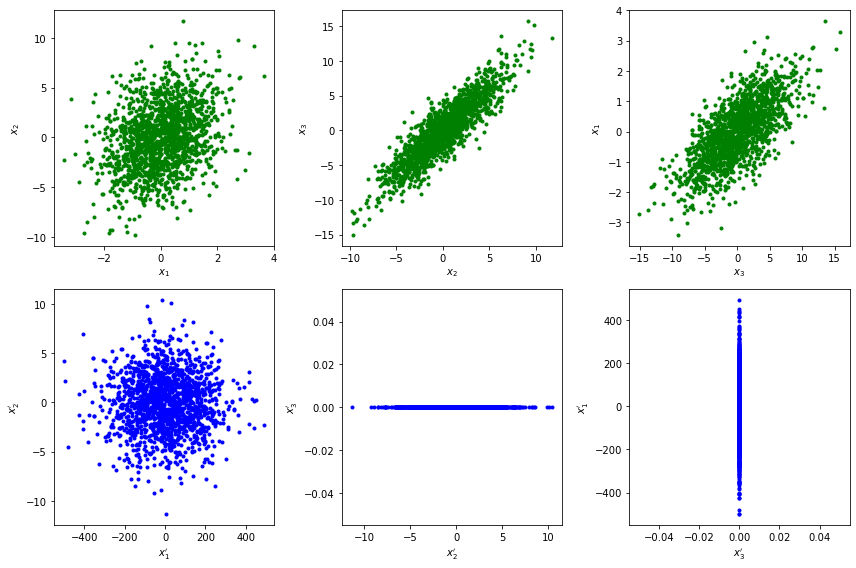

In [3]:
# reducing the dimensionality
spect_cov[percentage < 1e-2] = 0
base_cov = numpy.array([l*v for l,v in zip(spect_cov,V_cov)])

# new dataset in the new basis
new_features = ['x1\'','x2\'','x3\'']
dataset_new = pandas.DataFrame(numpy.dot(base_cov, dataset.values.T).T, columns=new_features)

# plot the datasets
print("We now plot in green the original dataset and in blue the new dataset")
fig, axs = plt.subplots(2, 3)
data = [dataset, dataset_new]
colours = ['g', 'b']
labels = [ ["$x_1$", "$x_2$", "$x_3$"], ["$x_1'$", "$x_2'$", "$x_3'$"] ]
for i in range(2):
    if i == 1: features = new_features
    for j in range(3):
        data[i].plot(x=features[j], y=features[(j+1)%3], ax=axs[i,j], linestyle='', marker='.', color=colours[i], legend=False, xlabel=labels[i][j], ylabel=labels[i][(j+1)%3])
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout()

# we now drop the 3rd component of the previous dataset (since is null)
dataset_new = dataset_new.loc[ :, (dataset_new != 0).any() ]

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

The percentage of variability is: [9.99586422e-01 4.13376663e-04 2.28342369e-08 2.21388736e-08
 2.17414672e-08 1.78481354e-08 2.06146294e-08 2.03737050e-08
 1.94295824e-08 1.98988842e-08 1.85188298e-08 1.83921512e-08]


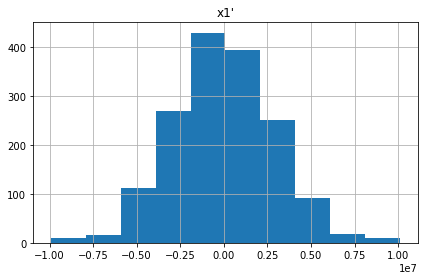

In [4]:
# starting from the previous dataset, we build up a new one with 10 dimensions of random noise
features = ["x"+str(i) for i in range(1,13)]
mu_noise, sigma_noise = 0, 1/50
noise_values = numpy.array([mu_noise + sigma_noise * rnd.randn(N) for i in range(10)]).T

dataset = pandas.DataFrame(numpy.hstack((dataset_new.values, noise_values)), columns=features)

# eigenvalues and eigenvectors of the covariance matrix
cov = numpy.cov(dataset.values.T)
spect, V = linalg.eig(cov)
eigenval = numpy.real_if_close(spect)
eigenvec = V.T

# work out the percentage of the dataset variability
percentage = eigenval / cov.trace()
print(f"The percentage of variability is: {percentage}")

# determine the new base
eigenval[percentage < 1e-02] = 0
base = numpy.array([l*v for l,v in zip(eigenval,eigenvec)])
reduced_dataset = (base @ dataset.values.T).T

# reducing the dimensionality
new_features = ['x'+str(i)+'\'' for i in range(1,reduced_dataset.shape[1]+1)]
reduced_dataset = pandas.DataFrame(reduced_dataset, columns=new_features)
reduced_dataset = reduced_dataset.loc[ :, (reduced_dataset != 0).any() ]

# plot the dataset
fig, ax = plt.subplots(1)
reduced_dataset.hist(ax=ax)
fig.tight_layout()

In the previous exercise we kept two dimensions to describe the $99\%$ of the variability. In this case, since we added many dimensions for the noise, the percentage of the variability that the second dimension represented has decreased. In order to describe the $99\%$ of the variability it's now sufficient to keep just one dimension.

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


In [25]:
# setting the parameters for the oscillator
period = 2
rest_x_pos = 4
amplitude = 3

# setting the measurements
N = 1600
time_records = numpy.linspace(0, 10, N)
x_records = rest_x_pos + amplitude * numpy.cos(2 * pi / period * time_records)

# setting the noise
y_records = 0.1 * rnd.randn(N)

# including the third spacial dimension
z_records = numpy.zeros(N)

# positions dataset
pos_records = numpy.vstack((x_records, y_records, z_records))

# PCA on the original dataset


# setting the parameters for the n cameras
n = 7
angles_cameras = numpy.vstack((rnd.uniform(0, pi, n), rnd.uniform(0, 2*pi, n))).T
angles_cameras

array([[0.3396337 , 4.42739671],
       [0.59002491, 3.9245013 ],
       [0.51831608, 1.05037904],
       [1.16667979, 4.05011712],
       [0.56398072, 0.6696937 ],
       [1.82851596, 3.24976306],
       [1.90880462, 1.62148901]])

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [6]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ./data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ./data/
#!rm -r ./data/